In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from joblib import load

from config import EXPERIMENT, RUN_NAME, ARTIFACT_DIR
from logger import logger
from mlflow_utils import evaluate_binary, log_mlflow

In [3]:
# Tag this cell as 'parameters'
INDEX = 'SNP'

In [4]:
# Wrap all this is a parameter dict
run_params = {'experiment': EXPERIMENT,
              'iteration': RUN_NAME,
              'index': INDEX,
              'artifact_dir': ARTIFACT_DIR}

### Import data

In [5]:
df = pd.read_csv('../datadir/{}.csv'.format(INDEX))

### Data prep

In [6]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [7]:
df.sort_values(by='date', ascending=True, inplace=True)  # Have to sort ascending for rolling to work correctly

### Create basic features

In [8]:
df = df[['date', 'open', 'adj_close']].copy()

In [9]:
df['prev'] = df['adj_close'].shift(1)

In [10]:
df['sma2'] = df['prev'].rolling(window=2).mean()
df['sma5'] = df['prev'].rolling(window=5).mean()
df['sma10'] = df['prev'].rolling(window=10).mean()
df['sma20'] = df['prev'].rolling(window=20).mean()

In [11]:
assert round(df['prev'].tail(5).mean(), 4) == round(df['sma5'].tail(1).item(), 4), 'Expected sma5 to be same as mean of past 5 items'
assert round(df['prev'].tail(10).mean(), 4) == round(df['sma10'].tail(1).item(), 4), 'Expected sma10 to be same as mean of past 10 items'
assert round(df['prev'].tail(20).mean(), 4) == round(df['sma20'].tail(1).item(), 4), 'Expected sma20 to be same as mean of past 20 items'

In [12]:
df['ema12'] = df['prev'].ewm(span=12, min_periods=12, adjust=False).mean()
df['ema26'] = df['prev'].ewm(span=26, min_periods=26, adjust=False).mean()

In [13]:
def difference(prev_price, moving_average):
    return (prev_price - moving_average) / prev_price

In [14]:
for col in ['sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']:
    df['{}_diff'.format(col)] = difference(df['prev'], df[col])

In [15]:
df.dropna(inplace=True)

In [16]:
df.shape

(227, 16)

In [17]:
df.drop(columns=['date', 'open'], inplace=True)

### Create label

In [18]:
df['label'] = (df['adj_close'] > df['prev']).astype(int)

### Train-val split

In [19]:
# Keep most recent 20 days as validation set

In [19]:
validation_days = 20
train = df.iloc[:-validation_days].copy()
val = df.iloc[-validation_days:].copy()
logger.info('No. of days - Train: {}, Val: {}'.format(train.shape[0], val.shape[0]))

2021-07-19 00:38:00,331 - No. of days - Train: 207, Val: 20


### Basic visualizations

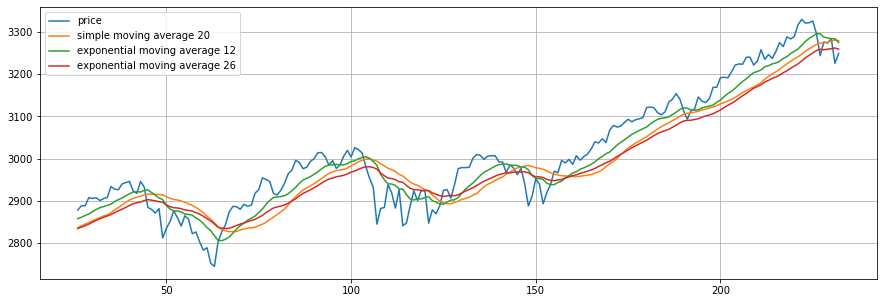

In [20]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(train['adj_close'], label='price')
plt.plot(train['sma20'], label='simple moving average 20')
plt.plot(train['ema12'], label='exponential moving average 12')
plt.plot(train['ema26'], label='exponential moving average 26')
plt.legend()

### Feature transformations

In [21]:
scaler = StandardScaler()

In [22]:
COLS_TO_SCALE = ['prev', 'sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']

In [23]:
scaler.fit(train[COLS_TO_SCALE])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
train[COLS_TO_SCALE] = scaler.transform(train[COLS_TO_SCALE])
val[COLS_TO_SCALE] = scaler.transform(val[COLS_TO_SCALE])

### Linear regression coefficients

In [25]:
x_variables = '+'.join(list(train.columns[1:-1]))
logger.info('x variables: {}'.format(x_variables))

2021-07-19 00:38:07,586 - x variables: prev+sma2+sma5+sma10+sma20+ema12+ema26+sma2_diff+sma5_diff+sma10_diff+sma20_diff+ema12_diff+ema26_diff


In [26]:
results = smf.ols('adj_close ~ {}'.format(x_variables), data=train).fit()

In [27]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     578.1
Date:                Mon, 19 Jul 2021   Prob (F-statistic):          8.72e-147
Time:                        00:38:09   Log-Likelihood:                -930.76
No. Observations:                 207   AIC:                             1890.
Df Residuals:                     193   BIC:                             1936.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3041.1045     46.445     65.478      0.0

### Drop label col

In [28]:
train.drop(columns=['adj_close'], inplace=True)
val.drop(columns=['adj_close'], inplace=True)

### Logistic Regression Coefficients

In [29]:
y = train['label'].values
X = train.drop(columns=['label'])

In [30]:
X = add_constant(X)

In [31]:
logit = sm.Logit(y, X)

In [32]:
result = logit.fit()
print(result.summary())

         Current function value: 1.780240
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  207
Model:                          Logit   Df Residuals:                      193
Method:                           MLE   Df Model:                           13
Date:                Mon, 19 Jul 2021   Pseudo R-squ.:                  -1.617
Time:                        00:38:16   Log-Likelihood:                -368.51
converged:                      False   LL-Null:                       -140.84
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3716     15.369      4.188      0.000      34.249      94.494
prev        -596.4932    150.250     -3.970      0.000    -890.97

C:\Users\kenne\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


### Train some basic models

In [33]:
y_train = train['label'].values
X_train = train.drop(columns='label').values

y_val = val['label'].values
X_val = val.drop(columns='label').values

In [ ]:
# Logistic regression
model_name = 'Logistic Regression'
model = LogisticRegression(fit_intercept=False).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

2021-07-19 00:43:51,177 - AUC: 0.293 | Recall: 1.000 | Precision: 0.450 | F1: 0.621
2021-07-19 00:43:51,286 - ROC curve saved to: ../artifact_dir/plots/roc_curve_Support_Vector_Classifier (auc = 0.29).png
2021-07-19 00:43:51,491 - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Support_Vector_Classifier (prec = 0.45, recall = 1.00).png
2021-07-19 00:43:51,495 - Model saved to: ../artifact_dir/models/Support_Vector_Classifier.pickle


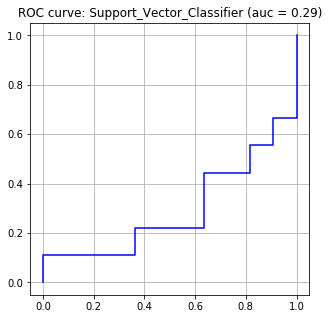

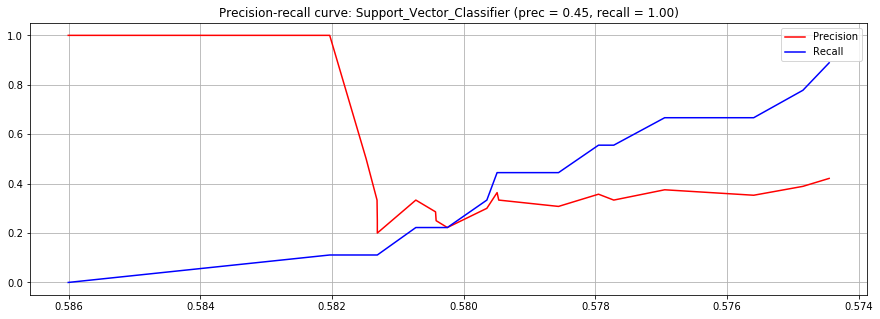

In [39]:
# Support vector classifier
model_name = 'Support Vector Classifier'
model = SVC(gamma=2, C=1, probability=True).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

2021-07-19 00:43:44,725 - AUC: 0.480 | Recall: 0.333 | Precision: 0.429 | F1: 0.375
2021-07-19 00:43:44,813 - ROC curve saved to: ../artifact_dir/plots/roc_curve_K-nearest Neighbours (auc = 0.48).png
2021-07-19 00:43:44,959 - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_K-nearest Neighbours (prec = 0.43, recall = 0.33).png
2021-07-19 00:43:44,959 - Model saved to: ../artifact_dir/models/K-nearest Neighbours.pickle
2021/07/19 00:43:45 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH env

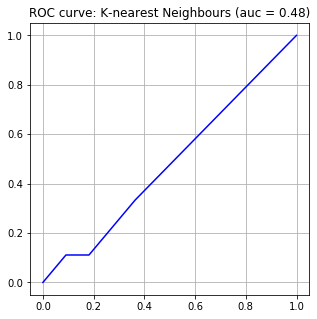

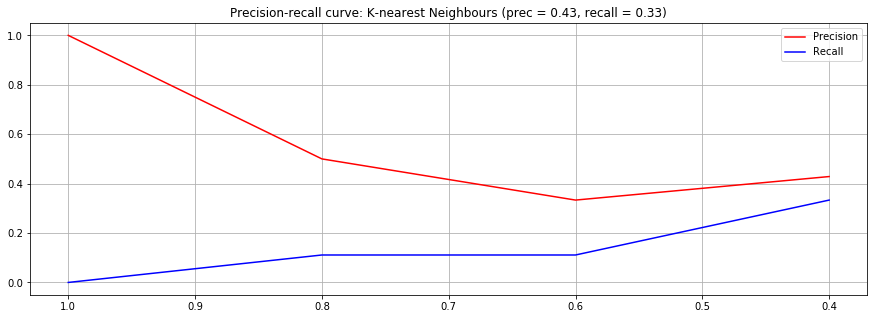

In [38]:
# K-neighbours
model_name = 'K-nearest Neighbours'
model = KNeighborsClassifier(5).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

2020-03-08 13:27:05,658 - AUC: 0.323 | Recall: 0.222 | Precision: 0.250 | F1: 0.235
2020-03-08 13:27:05,810 - ROC curve saved to: ../artifact_dir/plots/roc_curve_Gradient Boosting Machine (auc = 0.32).png
2020-03-08 13:27:05,936 - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Gradient Boosting Machine (prec: 0.25, recall: 0.22).png
2020-03-08 13:27:05,937 - Model saved to: ../artifact_dir/models/Gradient Boosting Machine.pickle


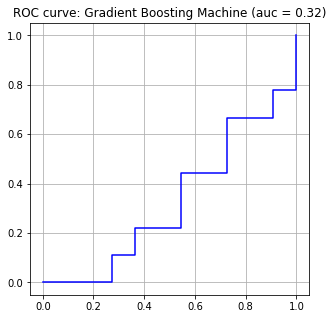

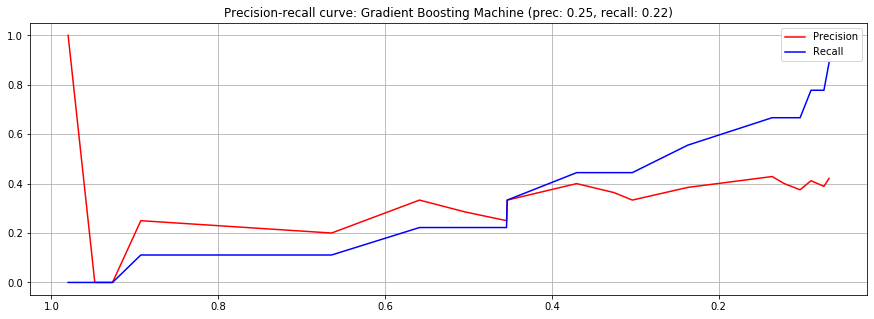

In [39]:
# Gradient Boosting
model_name = 'Gradient Boosting Machine'
model = GradientBoostingClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

2020-03-08 13:27:06,407 - AUC: 0.500 | Recall: 0.444 | Precision: 0.444 | F1: 0.444
2020-03-08 13:27:06,483 - ROC curve saved to: ../artifact_dir/plots/roc_curve_Extra Trees (auc = 0.50).png
2020-03-08 13:27:06,617 - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Extra Trees (prec: 0.44, recall: 0.44).png
2020-03-08 13:27:06,617 - Model saved to: ../artifact_dir/models/Extra Trees.pickle


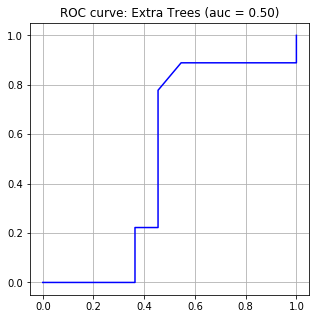

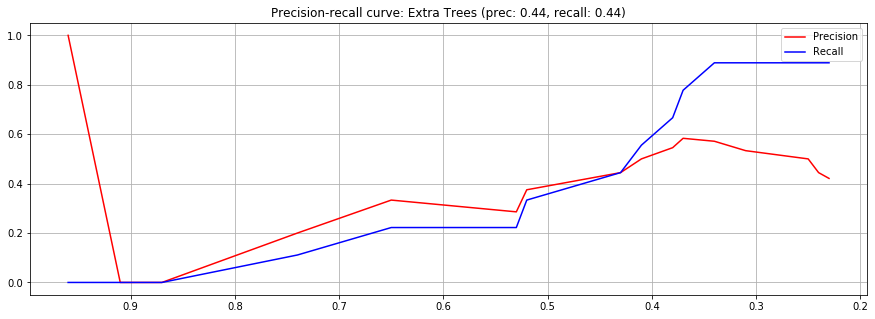

In [40]:
# Bagged trees
model_name = 'Extra Trees'
model = ExtraTreesClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

### Test loading model

In [43]:
model_name = 'Support Vector Classifier'
check_model = load('{}/models/{}.pickle'.format(ARTIFACT_DIR, model_name))

In [44]:
check_model

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [45]:
pred = check_model.predict_proba(X_val)[:, 1]

In [46]:
evaluate_binary(y_val, pred)

2020-03-08 13:27:15,693 - AUC: 0.707 | Recall: 1.000 | Precision: 0.450 | F1: 0.621


(0.7070707070707071, 1.0, 0.45, 0.6206896551724138)